In [20]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from wordcloud import WordCloud
from pymongo import MongoClient

In [2]:
mongo_client = MongoClient("mongodb+srv://<user>:<password>@okcupid.njnu4m5.mongodb.net/") #Update Your Code Here
mongo_database = mongo_client.OKCupid
mongo_collection = mongo_database.OKCupid

In [3]:
all_documents = mongo_collection.find().limit(10)
all_documents[0]

{'_id': ObjectId('66043c9f0d794818da3d5514'),
 'age': 22,
 'status': 'single',
 'sex': 'm',
 'orientation': 'straight',
 'body_type': 'a little extra',
 'diet': 'strictly anything',
 'drinks': 'socially',
 'drugs': 'never',
 'education': 'working on college/university',
 'ethnicity': 'asian, white',
 'height': 75,
 'income': -1,
 'job': 'transportation',
 'last_online': '2012-06-28-20-30',
 'location': 'south san francisco, california',
 'offspring': "doesn't have kids, but might want them",
 'pets': 'likes dogs and likes cats',
 'religion': 'agnosticism and very serious about it',
 'sign': 'gemini',
 'smokes': 'sometimes',
 'speaks': 'english',
 'essay0': "about me:  i would love to think that i was some some kind of intellectual: either the dumbest smart guy, or the smartest dumb guy. can't say i can tell the difference. i love to talk about ideas and concepts. i forge odd metaphors instead of reciting cliches. like the simularities between a friend of mine's house and an underwater 

In [4]:
popularity_pipeline = [
    # Match documents where structured attributes and essay fields are present
    {
        '$match': {
            '$and': [
                # Structured attributes
                {'income': {'$exists': True, '$type': 'number', '$gte': 0}},  # Added condition here
                {'diet': {'$exists': True, '$ne': None, '$ne': '', '$ne': 'null'}},
                {'drinks': {'$exists': True, '$ne': None, '$ne': '', '$ne': 'null'}},
                {'smokes': {'$exists': True, '$ne': None, '$ne': '', '$ne': 'null'}},
                {'sex': {'$exists': True, '$ne': None, '$ne': '', '$ne': 'null'}},
                
                # Essay fields
                {'$or': [
                    {'essay0': {'$exists': True, '$ne': None, '$ne': '', '$ne': 'null'}},
                    {'essay1': {'$exists': True, '$ne': None, '$ne': '', '$ne': 'null'}},
                    {'essay2': {'$exists': True, '$ne': None, '$ne': '', '$ne': 'null'}},
                    {'essay3': {'$exists': True, '$ne': None, '$ne': '', '$ne': 'null'}},
                    {'essay4': {'$exists': True, '$ne': None, '$ne': '', '$ne': 'null'}},
                    {'essay5': {'$exists': True, '$ne': None, '$ne': '', '$ne': 'null'}},
                    {'essay6': {'$exists': True, '$ne': None, '$ne': '', '$ne': 'null'}},
                    {'essay7': {'$exists': True, '$ne': None, '$ne': '', '$ne': 'null'}},
                    {'essay8': {'$exists': True, '$ne': None, '$ne': '', '$ne': 'null'}},
                    {'essay9': {'$exists': True, '$ne': None, '$ne': '', '$ne': 'null'}}
                ]}
            ]
        }
    },
    
    # Project fields for analysis
    {
        '$project': {
            'income': 1,
            'diet': 1,
            'drinks': 1,
            'smokes': 1,
            'sex':1,
            'essay0': {'$cond': [{'$isArray': ['$essay0']}, {'$reduce': {'input': '$essay0', 'initialValue': '', 'in': {'$concat': ['$$value', ' ', {'$toString': '$$this'}]}}}, {'$toString': {'$ifNull': ['$essay0', '']}}]},
            'essay1': {'$cond': [{'$isArray': ['$essay1']}, {'$reduce': {'input': '$essay1', 'initialValue': '', 'in': {'$concat': ['$$value', ' ', {'$toString': '$$this'}]}}}, {'$toString': {'$ifNull': ['$essay1', '']}}]},
            'essay2': {'$cond': [{'$isArray': ['$essay2']}, {'$reduce': {'input': '$essay2', 'initialValue': '', 'in': {'$concat': ['$$value', ' ', {'$toString': '$$this'}]}}}, {'$toString': {'$ifNull': ['$essay2', '']}}]},
            'essay3': {'$cond': [{'$isArray': ['$essay3']}, {'$reduce': {'input': '$essay3', 'initialValue': '', 'in': {'$concat': ['$$value', ' ', {'$toString': '$$this'}]}}}, {'$toString': {'$ifNull': ['$essay3', '']}}]},
            'essay4': {'$cond': [{'$isArray': ['$essay4']}, {'$reduce': {'input': '$essay4', 'initialValue': '', 'in': {'$concat': ['$$value', ' ', {'$toString': '$$this'}]}}}, {'$toString': {'$ifNull': ['$essay4', '']}}]},
            'essay5': {'$cond': [{'$isArray': ['$essay5']}, {'$reduce': {'input': '$essay5', 'initialValue': '', 'in': {'$concat': ['$$value', ' ', {'$toString': '$$this'}]}}}, {'$toString': {'$ifNull': ['$essay5', '']}}]},
            'essay6': {'$cond': [{'$isArray': ['$essay6']}, {'$reduce': {'input': '$essay6', 'initialValue': '', 'in': {'$concat': ['$$value', ' ', {'$toString': '$$this'}]}}}, {'$toString': {'$ifNull': ['$essay6', '']}}]},
            'essay7': {'$cond': [{'$isArray': ['$essay7']}, {'$reduce': {'input': '$essay7', 'initialValue': '', 'in': {'$concat': ['$$value', ' ', {'$toString': '$$this'}]}}}, {'$toString': {'$ifNull': ['$essay7', '']}}]},
            'essay8': {'$cond': [{'$isArray': ['$essay8']}, {'$reduce': {'input': '$essay8', 'initialValue': '', 'in': {'$concat': ['$$value', ' ', {'$toString': '$$this'}]}}}, {'$toString': {'$ifNull': ['$essay8', '']}}]},
            'essay9': {'$cond': [{'$isArray': ['$essay9']}, {'$reduce': {'input': '$essay9', 'initialValue': '', 'in': {'$concat': ['$$value', ' ', {'$toString': '$$this'}]}}}, {'$toString': {'$ifNull': ['$essay9', '']}}]}
        }
    },
    
    # Add a field to categorize income groups
    {
        '$addFields': {
            'income_group': {
                '$switch': {
                    'branches': [
                        {'case': {'$and': [{'$gte': ["$income", 100000]}, {'$lte': ["$income", 150000]}]}, 'then': "100000-150000"},
                        {'case': {'$and': [{'$gte': ["$income", 75000]}, {'$lte': ["$income", 99999]}]}, 'then': "75000-99999"},
                        {'case': {'$and': [{'$gte': ["$income", 50000]}, {'$lte': ["$income", 74999]}]}, 'then': "50000-74999"},
                        {'case': {'$lte': ["$income", 49999]}, 'then': "Less than 50000"},
                    ],
                    'default': "Unknown"
                }
            },
            'sex': {
                '$cond': [{'$eq': ['$sex', 'f']},'Female',
                {'$cond': [{'$eq': ['$sex', 'm']},'Male','Female']}
                ]
            }
        }
    },
]

# Execute the aggregation pipeline
popularity_results = list(mongo_database.OKCupid.aggregate(popularity_pipeline, allowDiskUse=True))

In [6]:
# Group by smokes
popularity_pipeline.append({
    '$group': {
        '_id': {'smokes': "$smokes", 'sex': "$sex"},
        'avg_income': {'$avg': '$income'},
        'count': {'$sum': 1},
        'essays': {'$push': '$essay0'}
    }
},)

# Calculate total count
popularity_pipeline.append({
    '$group': {
        '_id': None,
        'total_count': {'$sum': '$count'},
        'data': {'$push': '$$ROOT'}
    }
})

# Unwind the data array
popularity_pipeline.append({
    '$unwind': '$data'
})

# Project the final structure and calculate percentage
popularity_pipeline.append(
    {
        '$project': {
            '_id': '$data._id',
            'avg_income': '$data.avg_income',
            'count': '$data.count',
            'essays': '$data.essays',
            'total_count': '$total_count',
            'percentage': {
                '$multiply': [{'$divide': ['$data.count', '$total_count']}, 100]
            }
        }
    },)

# Execute the aggregation pipeline
smoke_results = list(mongo_database.OKCupid.aggregate(popularity_pipeline, allowDiskUse=True))
popularity_pipeline.pop()
popularity_pipeline.pop()
popularity_pipeline.pop()
popularity_pipeline.pop()

{'$group': {'_id': {'smokes': '$smokes', 'sex': '$sex'},
  'avg_income': {'$avg': '$income'},
  'count': {'$sum': 1},
  'essays': {'$push': '$essay0'}}}

In [7]:
smoke_results[0]

{'_id': {'smokes': 'when drinking', 'sex': 'Female'},
 'avg_income': 94413.79310344828,
 'count': 145,
 'essays': ['hey i\'m angel, here\'s a little about myself. i am a born an raised californian, whoo. been in the bay area for a while now. i\'m a bit of a tomboy. i love video games, football (go niners), hiking, that kinda stuff. got to love the earth, so i try to stay conscious about how i effect the world and other people in it. i\'m into politics too , although i dont know a bunch about them but i try to learn more. a proud obama supporter and democrat, of course.  i\'m a fan of nature, music, fishing, bicycling, movies, art, good books, kid stuff and finding new things to get into. i\'m goin to school to become a chef, i love everything about food so it was a given for me. i\'m not what you say "religous" so i\'m into men with a mind for discovering other things. i\'ve found that i need a guy that is spiritual or its not really a good match.  i\'m working on goals right now, just

In [8]:
#Splitting the Data Based on Smoke
male_smoke_results =  [smd for smd in smoke_results if smd['_id']['sex'] == 'Male']
df_smoke_male = pd.DataFrame(male_smoke_results, columns=['_id','avg_income','count','essays','percentage'])
df_smoke_male[['smokes','sex']] = pd.DataFrame(df_smoke_male['_id'].tolist(), index=df_smoke_male.index)
df_smoke_male.drop('_id', axis=1, inplace=True)

female_smoke_results =  [smd for smd in smoke_results if smd['_id']['sex'] == 'Female']
df_smoke_female = pd.DataFrame(female_smoke_results, columns=['_id','avg_income', 'count','essays','percentage'])
df_smoke_female[['smokes', 'sex']] = pd.DataFrame(df_smoke_female['_id'].tolist(), index=df_smoke_female.index)
df_smoke_female.drop('_id', axis=1, inplace=True)

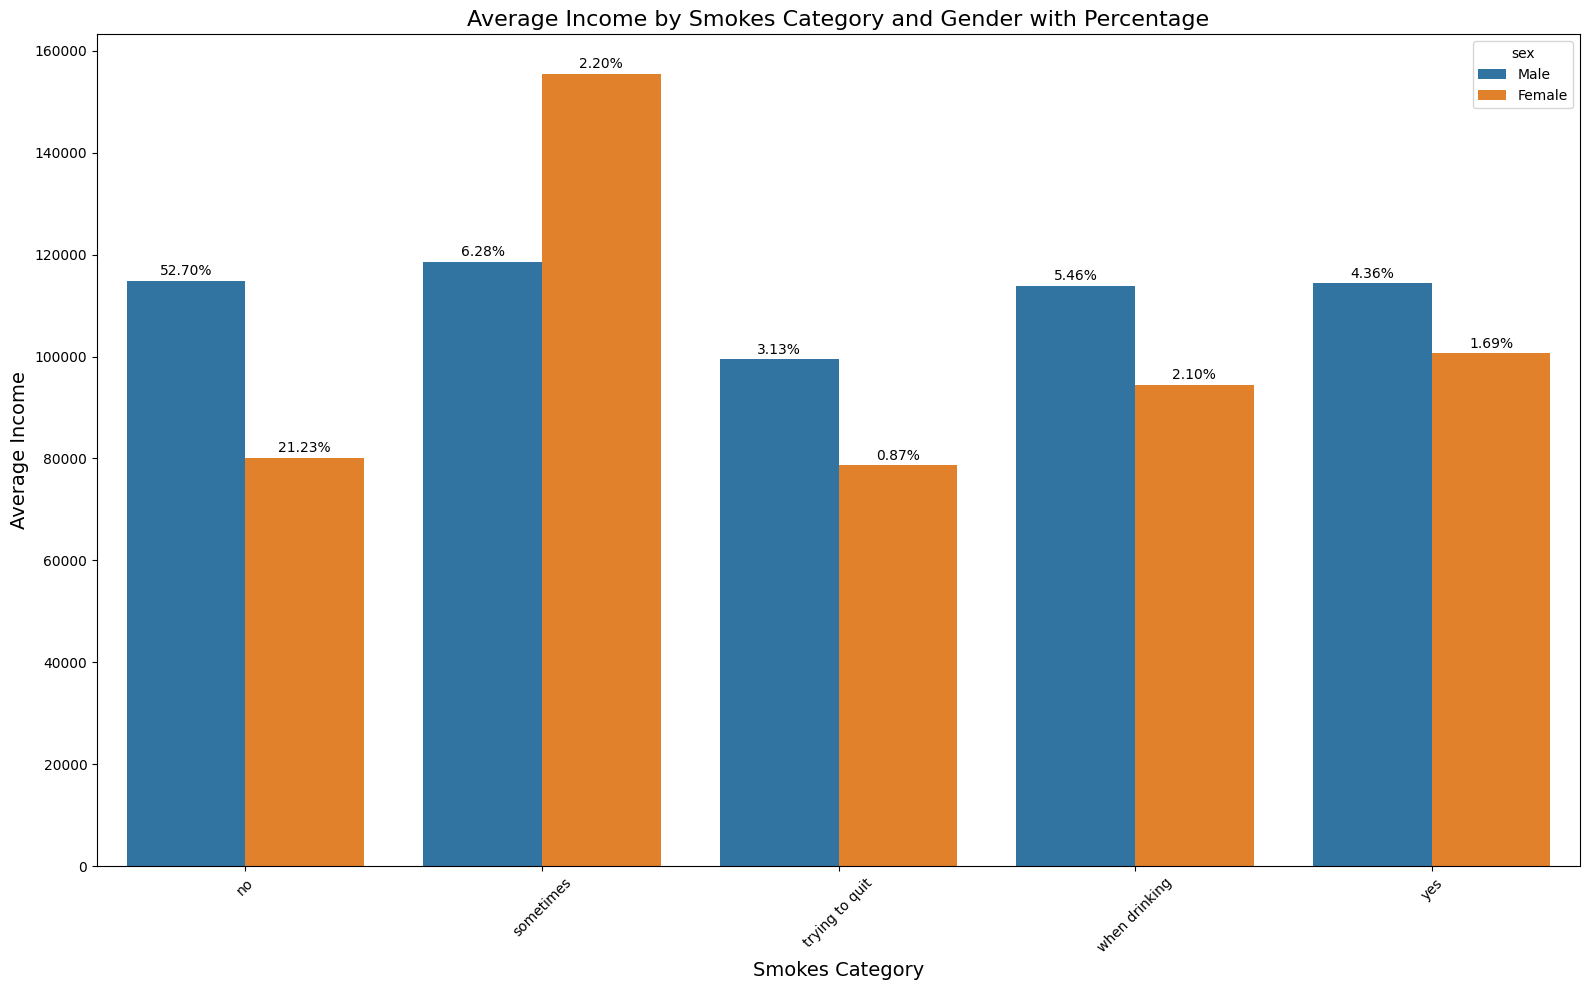

In [10]:
# Sample data
# Assuming df_male and df_female are your DataFrames for male and female data respective
# Add 'Gender' column to the DataFrames
df_smoke_male['Gender'] = 'Male'
df_smoke_female['Gender'] = 'Female'

# Create a combined DataFrame
df_smoke_combined = pd.concat([df_smoke_male, df_smoke_female],ignore_index=True)

# Convert percentage column to float
df_smoke_combined['percentage'] = df_smoke_combined['percentage']

# Sort DataFrame by 'smokes' column
df_smoke_combined = df_smoke_combined.sort_values(by='smokes')

# Create a bar plot
plt.figure(figsize=(16, 10))

# Create a barplot for each smokes category
sns.barplot(data=df_smoke_combined, x='smokes', y='avg_income', hue='sex', errorbar=None)

# Annotate bar values with percentage
si = 0
si_list = [value for idx, value in enumerate(df_smoke_combined['percentage']) if idx % 2 == 0] + [value for idx, value in enumerate(df_smoke_combined['percentage']) if idx % 2 != 0]

for bar, value in zip(plt.gca().patches, df_smoke_combined['percentage']):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 500, f"{si_list[si]:.2f}%", ha='center', va='bottom', fontsize=10)
    si = si + 1 

# Set labels and title
plt.xlabel('Smokes Category', fontsize=14)
plt.ylabel('Average Income', fontsize=14)
plt.title('Average Income by Smokes Category and Gender with Percentage', fontsize=16)
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

In [11]:
# Group by Drinks
popularity_pipeline.append({
    '$group': {
        '_id': {'drinks': "$drinks", 'sex': "$sex"},
        'avg_income': {'$avg': '$income'},
        'count': {'$sum': 1},
        'essays': {'$push': '$essay0'}
    }
},)

# Calculate total count
popularity_pipeline.append({
    '$group': {
        '_id': None,
        'total_count': {'$sum': '$count'},
        'data': {'$push': '$$ROOT'}
    }
})

# Unwind the data array
popularity_pipeline.append({
    '$unwind': '$data'
})

# Project the final structure and calculate percentage
popularity_pipeline.append(
    {
        '$project': {
            '_id': '$data._id',
            'avg_income': '$data.avg_income',
            'count': '$data.count',
            'essays': '$data.essays',
            'total_count': '$total_count',
            'percentage': {
                '$multiply': [{'$divide': ['$data.count', '$total_count']}, 100]
            }
        }
    },)

# Execute the aggregation pipeline
drink_results = list(mongo_database.OKCupid.aggregate(popularity_pipeline, allowDiskUse=True))
popularity_pipeline.pop()
popularity_pipeline.pop()
popularity_pipeline.pop()
popularity_pipeline.pop()

{'$group': {'_id': {'drinks': '$drinks', 'sex': '$sex'},
  'avg_income': {'$avg': '$income'},
  'count': {'$sum': 1},
  'essays': {'$push': '$essay0'}}}

In [12]:
#Splitting the Data Based on Drinks
male_drink_results =  [dd for dd in drink_results if dd['_id']['sex'] == 'Male']
df_drink_male = pd.DataFrame(male_drink_results, columns=['_id','avg_income','count','essays','percentage'])
df_drink_male[['drinks','sex']] = pd.DataFrame(df_drink_male['_id'].tolist(), index=df_drink_male.index)
df_drink_male.drop('_id', axis=1, inplace=True)

female_drink_results =  [dd for dd in drink_results if dd['_id']['sex'] == 'Female']
df_drink_female = pd.DataFrame(female_drink_results, columns=['_id','avg_income', 'count','essays','percentage'])
df_drink_female[['drinks', 'sex']] = pd.DataFrame(df_drink_female['_id'].tolist(), index=df_drink_female.index)
df_drink_female.drop('_id', axis=1, inplace=True)

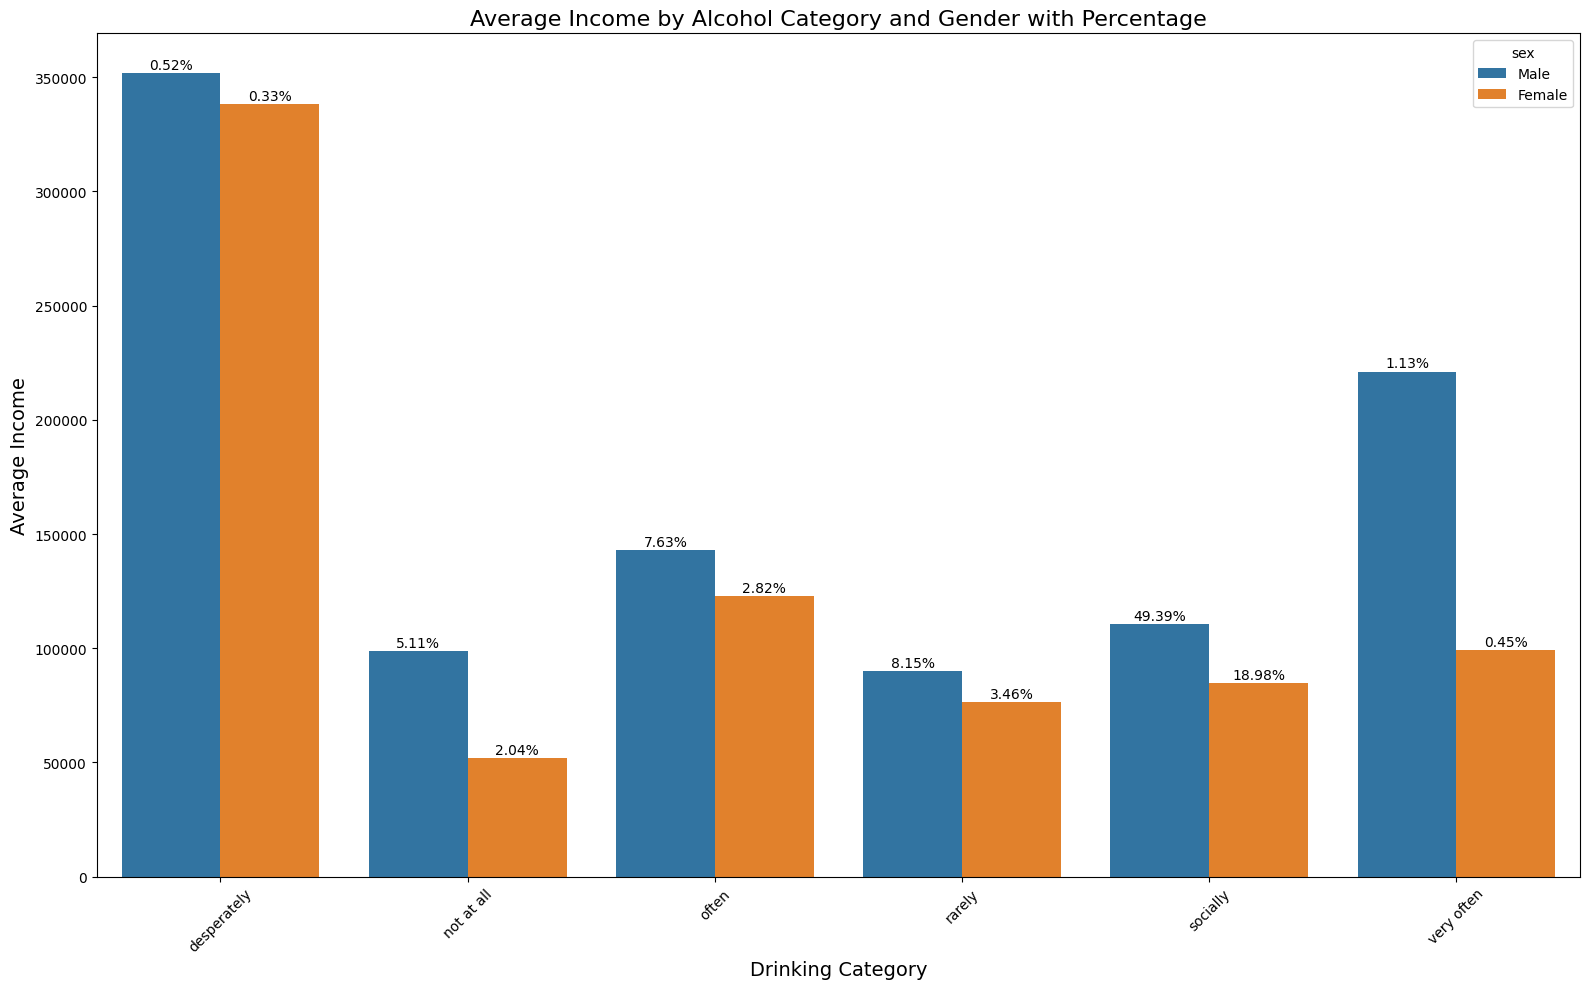

In [13]:
# Sample data
# Assuming df_male and df_female are your DataFrames for male and female data respective
# Add 'Gender' column to the DataFrames
df_drink_male['Gender'] = 'Male'
df_drink_female['Gender'] = 'Female'

# Create a combined DataFrame
df_drink_combined = pd.concat([df_drink_male, df_drink_female],ignore_index=True)

# Convert percentage column to float
df_drink_combined['percentage'] = df_drink_combined['percentage']

# Sort DataFrame by 'smokes' column
df_drink_combined = df_drink_combined.sort_values(by='drinks')

# Create a bar plot
plt.figure(figsize=(16, 10))

# Create a barplot for each smokes category
sns.barplot(data=df_drink_combined, x='drinks', y='avg_income', hue='sex', errorbar=None)

# Annotate bar values with percentage
di = 0
di_list = [value for idx, value in enumerate(df_drink_combined['percentage']) if idx % 2 == 0] + [value for idx, value in enumerate(df_drink_combined['percentage']) if idx % 2 != 0]

for bar, value in zip(plt.gca().patches, df_drink_combined['percentage']):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 500, f"{di_list[di]:.2f}%", ha='center', va='bottom', fontsize=10)
    di = di + 1 

# Set labels and title
plt.xlabel('Drinking Category', fontsize=14)
plt.ylabel('Average Income', fontsize=14)
plt.title('Average Income by Alcohol Category and Gender with Percentage', fontsize=16)
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

In [15]:
# Group by Smokes and Drinks
popularity_pipeline.append({
    '$group': {
        '_id': {'smokes': "$smokes", 'drinks': "$drinks", 'sex': "$sex"},
        'avg_income': {'$avg': '$income'},
        'count': {'$sum': 1},
        'essays': {'$push': '$essay0'}
    }
},)

# Calculate total count
popularity_pipeline.append({
    '$group': {
        '_id': None,
        'total_count': {'$sum': '$count'},
        'data': {'$push': '$$ROOT'}
    }
})

# Unwind the data array
popularity_pipeline.append({
    '$unwind': '$data'
})

# Project the final structure and calculate percentage
popularity_pipeline.append(
    {
        '$project': {
            '_id': '$data._id',
            'avg_income': '$data.avg_income',
            'count': '$data.count',
            'essays': '$data.essays',
            'total_count': '$total_count',
            'percentage': {
                '$multiply': [{'$divide': ['$data.count', '$total_count']}, 100]
            }
        }
    },)

# Execute the aggregation pipeline
smoke_drink_results = list(mongo_database.OKCupid.aggregate(popularity_pipeline, allowDiskUse=True))
popularity_pipeline.pop()
popularity_pipeline.pop()
popularity_pipeline.pop()
popularity_pipeline.pop()

{'$group': {'_id': {'smokes': '$smokes', 'drinks': '$drinks', 'sex': '$sex'},
  'avg_income': {'$avg': '$income'},
  'count': {'$sum': 1},
  'essays': {'$push': '$essay0'}}}

In [19]:
male_smoke_drink_results =  [d for d in smoke_drink_results if d['_id']['sex'] == 'Male']
df_male = pd.DataFrame(male_smoke_drink_results, columns=['_id','avg_income', 'count','essays','percentage'])
df_male[['smokes', 'drinks', 'sex']] = pd.DataFrame(df_male['_id'].tolist(), index=df_male.index)
df_male.drop('_id', axis=1, inplace=True)

female_smoke_drink_results =  [d for d in smoke_drink_results if d['_id']['sex'] == 'Female']
df_female = pd.DataFrame(female_smoke_drink_results, columns=['_id','avg_income', 'count','essays','percentage'])
df_female[['smokes', 'drinks', 'sex']] = pd.DataFrame(df_female['_id'].tolist(), index=df_female.index)
df_female.drop('_id', axis=1, inplace=True)

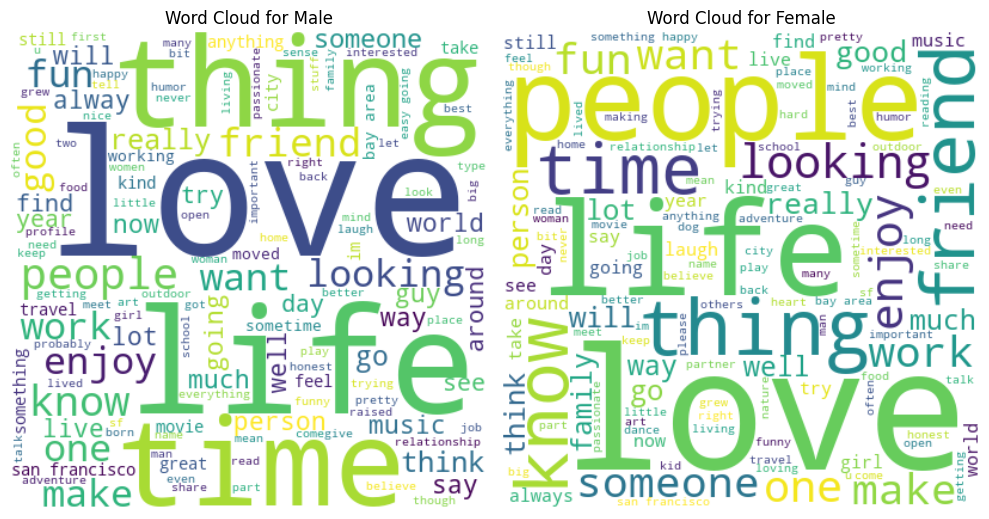

In [43]:
# Function to generate word cloud
def generate_wordcloud(text, title, position):
    wordcloud = WordCloud(width=400, height=400, background_color='white', stopwords=None, min_font_size=10).generate(text)
    plt.subplot(position)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis("off")
    plt.tight_layout(pad=0)

# Convert essay lists to single string for male and female dataframes
male_essays = ' '.join(df_male['essays'].explode().dropna())
female_essays = ' '.join(df_female['essays'].explode().dropna())

# Generate word cloud for male and female side by side
plt.figure(figsize=(10, 8))
generate_wordcloud(male_essays, 'Word Cloud for Male', 121)  # 1 row, 2 columns, first subplot
generate_wordcloud(female_essays, 'Word Cloud for Female', 122)  # 1 row, 2 columns, second subplot
plt.tight_layout()
plt.show()